In [1]:
%matplotlib inline

import tensorflow as tf

# <center><b>Towards GPflow 1.0</b></center>


<center><p>Artem Artemev</center>
<center><p>Cambridge, UK</center>


### Agenda


* Use TensorFlow "right".

* GPflow before.

* GPflow re-design.

* No conclusions has made.

# <center><b>"Simplicity is prerequisite for reliability."</b></center>

_<center><p><p>-Edsger Dijkstra</center>_

# <center><b>Use TensorFlow "right"</b></center>

### TensorFlow has two major terms

* Graph

* Session

### Graph

* It is only model definition... ?!
* Model's symbolic representation via operations and tensors.

* Graph is **immutable**. (1)
* Graph is a set of scopes - operations and variables.

* From (1) it follows that scopes are not modifiable too.

### Example

In [2]:
a = tf.get_variable('a', shape=())
b = tf.get_variable('b', shape=())

with tf.name_scope('c'):
    c1 = a + b

with tf.name_scope('c'):
    c2 = a + b

In [3]:
c1.name

'c/add:0'

In [4]:
c2.name

'c_1/add:0'

### Session

* Works with only graph.
* Executes graph operations.
* Allocates resources, not the **graph**.

### One model - one graph - many sessions !

* Only **graph definition** matters in GPflow design.

* **Session** can be interchangeable.

# <center><b>GPflow before</b></center>

### Status Quo

* One _flat_ TensorFlow variable contains all parameters.

* TensorFlow parameter name scope is _virtual_.

* Parameter as a FSM (finite state machine). For e.g. parameter has `recompile` flag.

* **Next things deserve stand-alone slides!**

### Hacky functions

* get_free_state

* get_feed_dict_keys

* update_feed_dict

* make_tf_array

* get_free_state

### Hacky functions

* Most of the code exist just to make this possible:
```python
def obj(x):
    self.num_fevals += 1
    feed_dict = {self._free_vars: x}
    self.update_feed_dict(self._feed_dict_keys, feed_dict)
    f, g = self.session.run([self._minusF, self._minusG], feed_dict=feed_dict)
    return f.astype(np.float64), g.astype(np.float64)
```

### Not clear interface

* When user should call `compile`?
* What autoflow does with model internals?

# <center><b>GPflow re-design</b></center>

### Main goals

* Use external graphs and sessions.

* One param - one TensorFlow variable.

* Optimization is not part of the model.

* Simple and clean design (as far as possible).

### Glossary

* **Build** is a process of defining the _graph_.

* **Compile** is a two phase process which consist of building and initialising for specific _session_. 

### Base

* _Build_ status enum class.

* _ICompilable_ interface.

* _Parentable_ class, underwent minimum amount of changes.


* _CompilableNode_ class joins two separate interfaces _ICompilable_ and _Parentable_. It implements common parts, provides useful methods.

* _AutoFlow_ class. It is not decorator anymore!

But _autoflow_ decorator still exists ;)

### Build status class

```python
class Build(enum.Enum):
    YES = 1
    NO = 0  # pylint: disable=C0103
    NOT_COMPATIBLE_GRAPH = None
```

### Compilable interface

```python
class ICompilable:
    __metaclass__ = abc.ABCMeta

    @abc.abstractproperty
    def graph(self):
        pass

    @abc.abstractmethod
    def compile(self, session=None, keep_session=False):
        pass

    @abc.abstractmethod
    def initialize(self, session=None):
        pass

    @abc.abstractmethod
    def is_built(self, graph=None):
        pass

    @abc.abstractmethod
    def _build(self):
        pass

    @abc.abstractmethod
    def clear(self):
        pass
```

In [12]:
A = gpflow.params.Parameterized(name='paramz')
external_param = tf.get_variable('external_param', shape=())
A.a = gpflow.params.Param(external_param)
A.b = gpflow.params.Param(100 * external_param + 1)
A.c = gpflow.params.Param(100)

NameError: name 'gpflow' is not defined

### Python - a scientific calculator



Whose calculator looks like this?

```python
>>> (131 + 21.5 + 100.2 + 88.7 + 99.5 + 100.5 + 200.5)/4
185.475
```


*Python 3 is my favorite calculator (not Python 2 because 1/2 = 0)*

Beyond basic operations:



- `fabs()`, `abs()`, `sin()`, `cos()`, `gcd()`, `log()` and more (See [math](https://docs.python.org/3/library/math.html))

- Descriptive statistics (See [statistics](https://docs.python.org/3/library/statistics.html#module-statistics))


### Python - a scientific calculator

- Develop your own functions: unit conversion, finding correlation, .., anything really

- Use PYTHONSTARTUP to extend the battery of readily available mathematical functions

```python
$ PYTHONSTARTUP=~/work/dmwp/pycon-us-2016/startup_math.py idle3 -s
```




### Unit conversion functions

```python

>>> unit_conversion()
1. Kilometers to Miles
2. Miles to Kilometers
3. Kilograms to Pounds
4. Pounds to Kilograms
5. Celsius to Fahrenheit
6. Fahrenheit to Celsius
Which conversion would you like to do? 6
Enter temperature in fahrenheit: 98
Temperature in celsius: 36.66666666666667
>>> 

```

### Finding linear correlation

```python
>>> 
>>> x = [1, 2, 3, 4]
>>> y = [2, 4, 6.1, 7.9]
>>> find_corr_x_y(x, y)
0.9995411791453812

```

So, that was Python and it's standard libraries. When you bring in third party libraries to the mix, Python becomes a seriously fancy calculator.

Who has heard about SymPy?

You can give it algebraic expressions to a function and a graph will be created for you.

You can give an equation and out comes the solutions for that equation.

We can even solve calculus problems.

### Python - a really fancy calculator

SymPy - a pure Python symbolic math library

*from sympy import awesomeness*  - don't try that :)




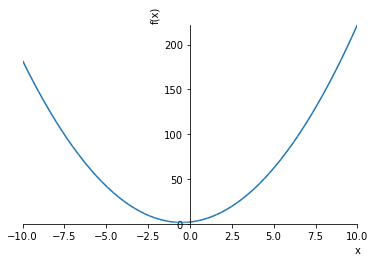

In [5]:
# Create graphs from algebraic expressions

from sympy import Symbol, plot
x = Symbol('x')
p = plot(2*x**2 + 2*x + 2)


In [6]:
# Solve equations

from sympy import solve, Symbol
x = Symbol('x')
solve(2*x + 1)


[-1/2]

In [7]:
# Limits

from sympy import Symbol, Limit, sin
x = Symbol('x')
Limit(sin(x)/x, x, 0).doit()




1

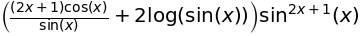

In [8]:
# Derivative

from sympy import Symbol, Derivative, sin, init_printing
x = Symbol('x')
init_printing()
Derivative(sin(x)**(2*x+1), x).doit()

In [9]:
# Indefinite integral

from sympy import Symbol, Integral, sqrt, sin, init_printing
x = Symbol('x')
init_printing()
Integral(sqrt(x)).doit()

In [10]:
# Definite integral

from sympy import Symbol, Integral, sqrt
x = Symbol('x')
Integral(sqrt(x), (x, 0, 2)).doit()

I will pause for a moment now. In the first two slides, we have seen how Python can be a super awesome calculator. What does that buy us? We have now been able to show that you can make computer programs literally do your homework. Write a program to do your work once and you will never have to make those lengthy calculations yourselves. Can we use Python to do more? 

Let's continue.

<center><h1>Can we do more than write smart calculators?</h1></center>



Python can be more than a super powerful calculator. We can use it to enhance the learning experience of other subjects. Next, I have three examples including a demo. First up, a video of a projectile motion. This program uses matplotlib's animation API to create a basic animation of a projectile motion - a fairly common subject introduced in introductory Physics. The program which is linked asks for the angle of projection and speed and then draws the trajectory of the projectile. Just by running the program multiple times, we can see how the trajectory changes. We don't have to go outside and start throwing balls..

Next, we will put Jupyter Notebook's interactive widgets to good effect by drawing a Barnsley Fern. Let's see how the demo goes.

Next, with the help of basemap, we can draw places on a world map like we would draw points on a graph paper.

I know I would be excited if someone was showing me all these cool things when I was learning these things!


### Python - Making other subjects more lively

<img align="center" src="images/collage1.png"></img>


- matplotlib

- basemap

- Interactive Jupyter Notebooks




#### Bringing Science to life

*Animation of a Projectile motion* [(Python Source)](https://github.com/doingmathwithpython/pycon-us-2016/blob/master/py-files/projectile_animation.py)




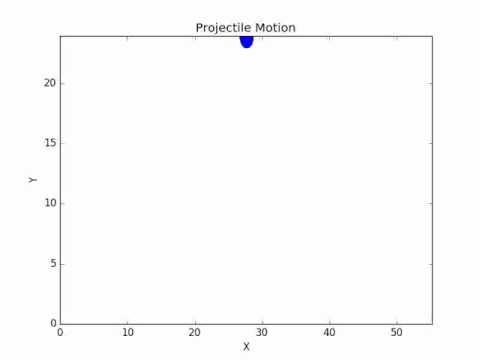

In [11]:
from IPython.display import YouTubeVideo
YouTubeVideo("8uWRVh58KdQ")

#### Exploring Fractals in Nature

*Interactively drawing a Barnsley Fern* [(Notebook)](https://github.com/doingmathwithpython/pycon-us-2016/blob/master/notebooks/Interactive%20Barnsley%20Fern.ipynb)



<img align="center" src="images/fern.jpg" width="400" ></img>



#### The world is your graph paper

*Showing places on a digital map* [(Notebook)](https://github.com/doingmathwithpython/pycon-us-2016/blob/master/notebooks/Maps%20using%20Basemap%20-%20demo.ipynb)

Next, I would like to talk about my book "Doing Math with Python". My idea was attractive enough to get it published by No Starch Press which makes me hope that I am probably onto something.

Has anybody read my book? What do you think of it? You have read it and came to my talk? I am feeling better :)

I discuss all of the topics I discuss today in my talk. In addition, I discuss sets, probability and random numbers and descriptive statistics.

It's being translated into several non-English languages.

The reviews/feedback so far has been really positive. I don't have any first hand involvement in teaching, so it's very appreciative of people to share their viewpoints with me.

### Book: Doing Math With Python

<img align="center" src="images/dmwp-cover.png" href="https://doingmathwithpython.github.io"></img>

Overview

- All of what I have discussed so far

- In addition: Descriptive statistics, Sets and Probability, Random numbers

Published by [No Starch Press](https://www.nostarch.com/doingmathwithpython) in August, 2015.

*Upcoming/In-progress translations*: Simplified Chinese, Japanese, French and Korean.

#### Comments

> Saha does an excellent job providing a clear link between Python and upper-level math concepts, and demonstrates how Python can be transformed into a mathematical stage. This book deserves a spot on every geometry teacher’s bookshelf.

[School Library Journal](http://www.slj.com/2016/05/collection-development/read-watch-alikes/coding-lets-begin/#_)


> Outstanding guide to using Python to do maths. Working back through my undergrad maths using Python.



> Saha does an excellent job providing a clear link between Python and upper-level math concepts, and demonstrates how Python can be transformed into a mathematical stage.


> This book is highly recommended for the high school or college student and anyone who is looking for a more natural way of programming math and scientific functions

> As a teacher I highly recommend this book as a way to work with someone in learning both math and programming


Okay, so that's great. We have successfully used Python to make the learning experience of young learners more fun and immediately applicable. Can we derive more benefit from doing that? Like something for the future? We all love doing things for the future, don't we?

I think yes, i think if we teach young learners the things we have discussed today, it is a great base for someone wanting to go into data science or machine learning.

Statistics and visualising data are two very key factors of data science.

Differential calculus and specifically the gradient descent method is a simple but useful optimization method used in Machine Learning. Let's see a demo of using gradient descent to find the minimum value of a function.

Now, let's apply gradient descent as an optimizer in a Linear Regression problem.

### Great base for the future

*Statistics and Graphing data* -> *Data Science*

*Differential Calculus* -> *Machine learning*


### Application of differentiation

Use gradient descent to find a function's minimum value [(Notebook)](https://github.com/doingmathwithpython/pycon-us-2016/blob/master/notebooks/Gradient%20Descent.ipynb)

### Predict the college admission score based on high school math score

Use gradient descent as the optimizer for single variable linear regression model [(Notebook)](https://github.com/doingmathwithpython/pycon-us-2016/blob/master/notebooks/Simple%20Linear%20Regression.ipynb)



### Advanced libraries

- [scipy](https://scipy.org)

- [numpy](http://www.numpy.org/)

- [scikit-learn](http://scikit-learn.org/stable/)

- [pandas](http://pandas.pydata.org/)

- [Statsmodels](http://statsmodels.sourceforge.net/)




### Dialogue

Questions, Thoughts, comments, discussions? 


#### Online 

- Twitter: @echorand

- Email: amitsaha.in@gmail.com
    


### PyCon Special!

*Use PYCONMATH code to get 30% off "Doing Math with Python" from [No Starch Press](https://www.nostarch.com/doingmathwithpython)*


<img align="center" src="images/dmwp-cover.png" href="https://doingmathwithpython.github.io"></img>


(Valid from  May 26th - June 8th) 

Book Signing - May 31st - 2.00 PM - No Starch Press booth

### Acknowledgements

PyCon US Education Summit team for inviting me



Thanks to PyCon US for reduced registration rates



Massive thanks to my employer, Freelancer.com for sponsoring my travel and stay 


### Links

- [Upcoming O'Reilly Webcast](http://www.oreilly.com/pub/e/3712)

- [Doing Math with Python](https://nostarch.com/doingmathwithpython)

- [Doing Math with Python Blog](https://doingmathwithpython.github.io)

- [Doing Math with Python on GitHub](https://github.com/doingmathwithpython)

